##### Imports

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np

import csv
import datetime

##### METHOD - writes new line to output.csv

In [9]:
def write_rows_on_csv(path, ticker, train_length, test_length, nth_pred, value, pred, accuracy, trend_validation):
    with open(path, "a", newline="") as file:
        writer = csv.writer(file)

        # Write new rows to the CSV file
        new_rows = [[ticker, train_length, test_length, nth_pred, value, pred, accuracy, trend_validation]]
        writer.writerows(new_rows)

##### METHOD - returns best degree for given X and y

In [3]:
def get_best_degree(X, y):
    r2A_hist = []
    r2_hist = []
    degrees = []

    n = len(X)
    k = 1

    for num in range(2, 15):
        hist_poly_reg = PolynomialFeatures(degree=num)

        hist_X_poly = hist_poly_reg.fit_transform(X)

        hist_poly_lin_reg = LinearRegression()
        hist_poly_lin_reg.fit(hist_X_poly, y)

        r2 = r2_score(y, hist_poly_lin_reg.predict(hist_X_poly))
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

        r2_hist.append(r2)
        r2A_hist.append(adj_r2)
        degrees.append(num)

    return degrees[r2A_hist.index(max(r2A_hist))]

##### METHOD - converts string to datetime

In [4]:
def str_to_datetime(timestamp):
  date_parts = timestamp.split('-')
  year, month, day = int(date_parts[0]), int(date_parts[1]), int(date_parts[2])
  return datetime.datetime(year=year, month=month, day=day)

##### METHOD - train regression and return predicted values

In [5]:
def train_regression(ticker, train_set_length, test_set_length):
    dataset_path = f"data/stock-data/{ticker}.SAO.csv"
    df = pd.read_csv(dataset_path)
    df = df[["timestamp", "close"]]
    df["timestamp"] = df["timestamp"].apply(str_to_datetime)
    df.index = df.pop("timestamp")

    # Dividing subset for training and testing
    train_df = df.iloc[test_set_length : test_set_length + train_set_length]
    test_df = df.iloc[:test_set_length + 1]

    # X and y from training
    train_y = train_df.values
    train_X = np.array([[i for i in reversed(range(len(train_y)))]]).reshape(-1, 1)

    # X and y from testing
    test_y = test_df.values
    test_X = np.array(
        [[i for i in reversed(range(len(train_y), len(train_y) + len(test_y)))]]
    ).reshape(-1, 1)

    # Defining model
    degree = get_best_degree(train_X, train_y)
    poly_reg = PolynomialFeatures(degree)
    poly_lin_reg = LinearRegression()

    # Training model
    train_X_poly = poly_reg.fit_transform(train_X)
    poly_lin_reg.fit(train_X_poly, train_y)
    train_y_pred = poly_lin_reg.predict(train_X_poly)

    # Testing model
    test_X_poly = poly_reg.fit_transform(test_X)
    test_y_pred = poly_lin_reg.predict(test_X_poly)

    return test_y, test_y_pred

##### Build results dataset

In [10]:
tickers_df = pd.read_csv("data/TICKERS.csv")
out_path = "out/poly-regression-results.csv"

with open(out_path, mode="w", newline="") as file:
    writer = csv.writer(file)

    # write header
    writer.writerow(
        [
            "ticker",
            "train_length",
            "test_length",
            "nth_pred",
            "value",
            "pred",
            "accuracy",
            "trend_validation"
        ]
    )

nth_days_pred = [1, 2, 7, 15, 20, 30, 40]
training_set_sizes = [365, 182, 90, 60, 30, 20]
test_set_sizes = [40, 55, 70, 85, 100, 115, 130, 145, 160, 175, 190]

for index, row in tickers_df.iterrows():
    for train_len in training_set_sizes:
        for test_len in test_set_sizes:
            for nth in nth_days_pred:
                results, pred_results = train_regression(
                    ticker=row["ticker"], train_set_length=train_len, test_set_length=test_len
                )

                nth_day_pred = pred_results[-(nth + 1)][0]
                nth_day = results[-(nth + 1)][0]

                accuracy = ((nth_day_pred / nth_day) - 1) * 100

                trend = not ((nth_day_pred > results[-1][0]) ^ (nth_day > results[-1][0]))

                write_rows_on_csv(
                    path=out_path,
                    ticker=row["ticker"],
                    train_length=train_len,
                    test_length=test_len,
                    nth_pred=nth,
                    value=nth_day,
                    pred=nth_day_pred,
                    accuracy=accuracy,
                    trend_validation=trend
                )

In [14]:
tickers_df = pd.read_csv("out/clustering-results.csv")

data_sizes = []

for index, row in tickers_df.iterrows():
    df = pd.read_csv(f"data/stock-data/{row['ticker']}.SAO.csv")
    data_sizes.append(len(df))

min(data_sizes)

582

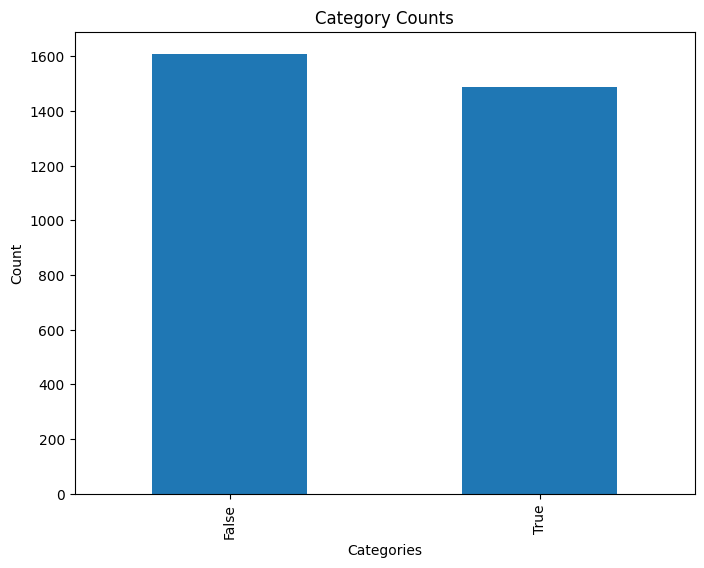

In [7]:
# Read the CSV file
df = pd.read_csv('output.csv')

# Replace 'your_column' with the actual column name in your CSV file
category_counts = df['trend_validation'].value_counts()

# Plot the chart
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Category Counts')
plt.show()
